# Reto | Generación de un modelo inteligente de clasificación con redes neuronales profundas para la detección de amenazas aéreas

**Objetivos**:
El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Preparar una base de datos y generar los conjuntos de entrenamiento y prueba.
- Diseñar un modelo utilizando una red neuronal convolucional desde cero y determinar sus hiperparámetros.
- Diseñar un modelo utilizando una red neuronal convolucional utilizando un modelo pre-entrenado.
- Generar un modelo utilizando la herramienta Teachable Machine.
- Validar, evaluar y comparar los tres diferentes modelos generados y seleccionar el mejor considerando la exactitud como indicador de desempeño.
- Exportar los modelos generados para poder utilizarlos dentro de Colab o algún otro sitio.

## 1. Preprocesamiento de la base de datos

In [1]:
# Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Eliminando cualquiero archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto/datos/objetos -type f ! -name "*.jpg" ! -name "*.jpeg" ! -name "*.png" -delete


In [4]:
# Directorio base
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
dir_base = pathlib.Path(dir_base)
conteo_img = len(list(dir_base.glob('*/*')))
print('El total de imágenes es de:',conteo_img)

El total de imágenes es de: 8218


In [5]:
# Correr si hay error al momento de entrenar el primer modelo
# for img_path in dir_base.rglob('*.[jp][pn]g'):
#     try:
#         img = tf.io.read_file(str(img_path))
#         img = tf.image.decode_image(img,channels=3)
#     except:
#         print('Error al decodificar:',img_path)
#         os.remove(img_path)

## 2. Generación de conjuntos de entrenamiento, prueba y aumentación de datos

In [6]:
# Tamaño de las imágenes y lote
alto_img = 160
ancho_img = 160
tam_lote = 64

Para la creación de los conjuntos de entrenamiento y prueba se usará la función:

```
image_dataset_from_directory
```



In [7]:
# Definición del conjunto de entrenamiento
conj_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

Found 8218 files belonging to 6 classes.
Using 6575 files for training.


In [8]:
# Definición del conjunto de prueba
conj_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

Found 8218 files belonging to 6 classes.
Using 1643 files for validation.


In [9]:
conj_entrenamiento = conj_entrenamiento.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
conj_prueba = conj_prueba.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## 3. Diseña una arquitectura de una red neuronal convolucional profunda desde cero para resolver el problema de clasificación


In [26]:

# Definición del primer modelo
redConv = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255,input_shape=(alto_img,ancho_img,3)),

    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1),


    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(96,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(6,activation='softmax')
])
redConv.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 160, 160, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ (None, 160, 160, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 40, 40, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 20, 20, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 20, 20, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 256,134 (1000.52 KB)

 Trainable params: 255,942 (999.77 KB)

 Non-trainable params: 192 (768.00 B)

In [23]:
# Compilación del modelo
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)
redConv.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Reducir learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [25]:
# Entrenamiento del modelo
evolucion = redConv.fit(
    conj_entrenamiento,
    validation_data = conj_prueba,
    epochs = 70,
    callbacks = [early_stopping,reduce_lr]
 )

Epoch 1/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.1790 - loss: 1.8405 - val_accuracy: 0.2258 - val_loss: 1.7877 - learning_rate: 1.0000e-04
Epoch 2/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.2306 - loss: 1.7611 - val_accuracy: 0.2307 - val_loss: 1.7868 - learning_rate: 1.0000e-04
Epoch 3/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.2497 - loss: 1.7428 - val_accuracy: 0.2276 - val_loss: 1.7792 - learning_rate: 1.0000e-04
Epoch 4/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.2456 - loss: 1.7317 - val_accuracy: 0.2514 - val_loss: 1.7534 - learning_rate: 1.0000e-04
Epoch 5/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.2699 - loss: 1.7192 - val_accuracy: 0.2830 - val_loss: 1.7087 - learning_rate: 1.0000e-04
Epoch 6/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.2762 - loss: 1.7145 - val_accuracy: 0.2958 - val_loss: 1.6941 - learning_rate: 1.0000e-04
Epoch 7/70
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 11

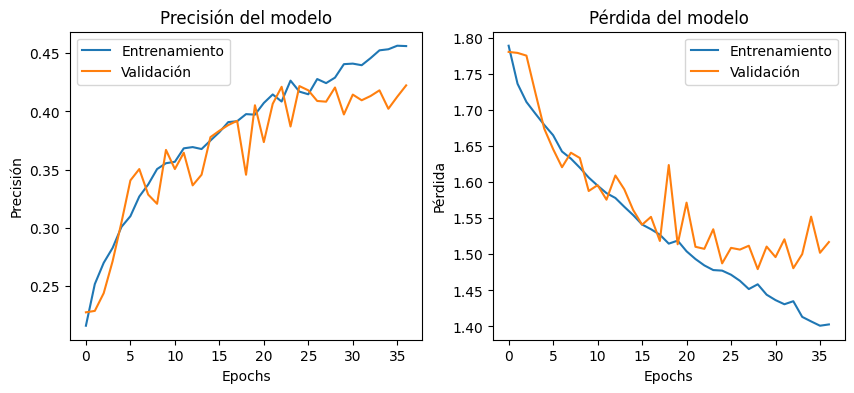

In [21]:
# Gráfico de la evolución de entrenamiento y pérdida
# Historial de entrenamiento
hist = evolucion.history
plt.figure(figsize=(10,4))

# Presición del modelo
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],label='Entrenamiento')
plt.plot(hist['val_accuracy'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()

# Pérdida del modelo
plt.subplot(1,2,2)
plt.plot(hist['loss'],label='Entrenamiento')
plt.plot(hist['val_loss'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.legend()

plt.show()

## 4. Diseña una arquitectura de una red neuronal convolucional profunda que utilice como base un modelo pre-entrenado para resolver el problema de clasificación

Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.



In [53]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.2),
])

# Configurar modelo pre-entrenado
forma_img = (160,160,3)
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape = forma_img,
    include_top = False,
    weights='imagenet'
)
modelo_base.trainable = False

Es importante normalizar los datos de entrada en la base convolucional.

In [59]:
from tensorflow.keras import regularizers
# Modelo completo
inputs = tf.keras.Input(shape=forma_img)
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1/255)(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(
    512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
modelo_pre = tf.keras.Model(inputs, outputs)
modelo_pre.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [60]:
# Fine-Tuning
modelo_base.trainable = True
for capa in modelo_base.layers[:-60]:
    capa.trainable = False

In [61]:
# Compilar modelo final
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Entrenamiento
historial_pre = modelo_pre.fit(
    conj_entrenamiento,
    epochs=30,
    validation_data = conj_prueba,
    callbacks = [early_stopping,reduce_lr]
)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.1690 - loss: 2.6002 - val_accuracy: 0.2757 - val_loss: 1.7908 - learning_rate: 1.0000e-05
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.2399 - loss: 2.1637 - val_accuracy: 0.3530 - val_loss: 1.6610 - learning_rate: 1.0000e-05
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.2576 - loss: 2.0521 - val_accuracy: 0.4139 - val_loss: 1.5580 - learning_rate: 1.0000e-05
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.3073 - loss: 1.8626 - val_accuracy: 0.4534 - val_loss: 1.4829 - learning_rate: 1.0000e-05
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.3520 - loss: 1.7769 - val_accuracy: 0.4906 - val_loss: 1.4161 - learning_rate: 1.0000e-05
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.3907 - loss: 1.6682 - val_accuracy: 0.5125 - val_loss: 1.3632 - learning_rate: 1.0000e-05
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 11

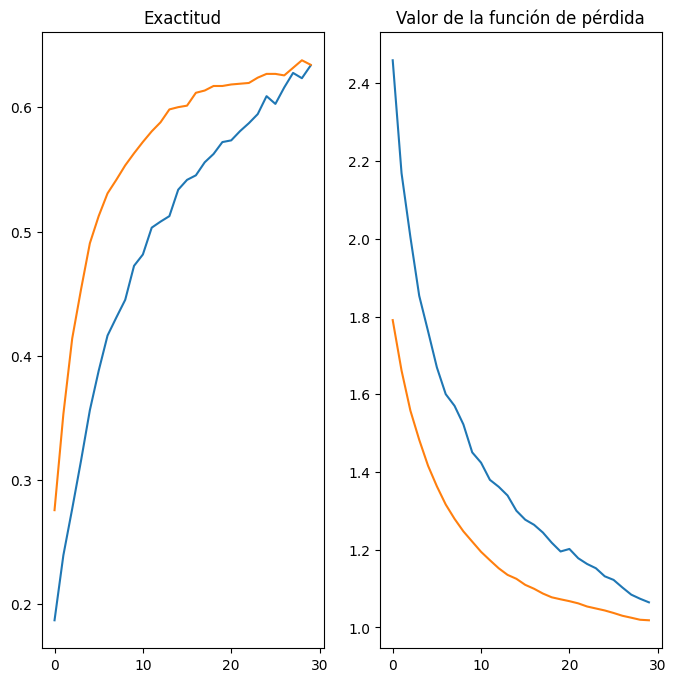

In [62]:
# Desempeño del Modelo
exactitud_pre = historial_pre.history['accuracy']
exactitud_val_pre = historial_pre.history['val_accuracy']

perdida_pre = historial_pre.history['loss']
perdida_val_pre = historial_pre.history['val_loss']

rango_epoca = range(30)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epoca,exactitud_pre,label='Exactitud Entrenamiento')
plt.plot(rango_epoca,exactitud_val_pre,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(rango_epoca,perdida_pre,label='Perdida Entrenamiento')
plt.plot(rango_epoca,perdida_val_pre,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()

## 5. Modelo con Teachable Machine
Para la generación del modelo en Teachable Machine se declararán 6 clases:
1. Misil
2. Jet
3. Helicóptero
4. Dron
5. Cohete
6. Avión

Para la creación del modelo se eligirán las primeras 200 imágenes de cada clase.

Los hiperparámetros serán los siguientes:

- Épocas: 50
- Tamaño del lote: 32
- Tasa de aprendizaje : 0.001

In [63]:
from keras import layers, Sequential
from PIL import Image, ImageOps
import numpy as np

# Definiendo ruta
ruta_modelo = '/content/drive/MyDrive/Reto/model.savedmodel1'

# Cargando modelo
modelo_tm = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    tf.keras.layers.TFSMLayer(ruta_modelo,call_endpoint='serving_default')
])

# Compilando el modelo
modelo_tm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## 6. Entrena y ajusta las arquitecturas diseñadas

### 6.1 Primer Modelo

### 6.2 Modelo Pre-entrenado

### 6.3 Modelo de Teachable Machine

## 7. Comparativa de los tres modelos generados en el problema de clasificación

### 7.1 Evaluación del Primer Modelo

In [64]:
# Pérdida y Exactitud
loss_redConv, acc_redConv = redConv.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_redConv:.4f}')
print(f' Exactitud del modelo: {acc_redConv:.4f}')

ValueError: You must call `compile()` before using the model.

### 7. 2 Evaluación del Modelo Pre-entrenado

In [65]:
loss_pre, acc_pre = modelo_pre.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_pre:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_pre:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6367 - loss: 1.0138
 Pérdida del modelo pre-entrenado: 1.0185
 Exactitud del modelo pre-entrenado: 0.6342


### 7.3 Evaluación del modelo de Teachable Machine

In [66]:
# Pérdida y Exactitud
loss_tm, acc_tm = modelo_tm.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_tm:.4f}')
print(f' Exactitud del modelo: {acc_tm:.4f}')

TypeError: Exception encountered when calling TFSMLayer.call().

[1mBinding inputs to tf.function failed due to `too many positional arguments`. Received args: (<tf.Tensor 'data:0' shape=(None, 160, 160, 3) dtype=float32>,) and kwargs: {} for signature: (*, sequential_1_input: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_1_input')) -> Dict[['sequential_3', TensorSpec(shape=(None, 6), dtype=tf.float32, name='sequential_3')]].
Fallback to flat signature also failed due to: Tensor Tensor("data:0", shape=(None, 160, 160, 3), dtype=float32) is not compatible with the shape this function was traced with. Expected shape (None, 224, 224, 3), but got shape (None, 160, 160, 3).

If you called get_concrete_function, you may need to pass a tf.TensorSpec(..., shape=...) with a less specific shape, having None on axes which can vary.[0m

Arguments received by TFSMLayer.call():
  • inputs=tf.Tensor(shape=(None, 160, 160, 3), dtype=float32)
  • training=False
  • kwargs=<class 'inspect._empty'>

### 7.4 Comparación de los tres modelos

In [67]:
exactitudes = [acc_redConv,acc_pre,acc_tm]
perdidas = [loss_redConv,loss_pre,loss_tm]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
plt.figure(figsize=(8,8))

# Precicisón
plt.subplot(1,2,1)
plt.bar(modelos,exactitudes)
plt.xlabel('Modelos')
plt.ylabel('Exactitud')
plt.title('Comparativa de desempeño de los modelos')

plt.subplot(1,2,2)
plt.bar(modelos,perdidas)
plt.xlabel('Modelos')
plt.ylabel('Pérdidas')
plt.title('Comparativa de las pérdidas de los modelos')
plt.show()


NameError: name 'acc_redConv' is not defined

## 8. Selección del mejor modelo

## 9. Modelos exportados

### 9.1 Primer Modelo

In [15]:
# Guardar modelo
redConv.save('/content/drive/MyDrive/Reto/modelo_redConv.keras')

# Cargar modelo
modelo_redConv = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_redConv.keras')

### 9.2 Modelo pre-entrenado

In [68]:
# Guardar modelo
modelo_pre.save('/content/drive/MyDrive/Reto/modelo_pre.keras')

# Cargar modelo
modelo_prentrenado = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_pre.keras')

### 9.3 Modelo de Teachable Machine

In [ ]:
# Cargar modelo

modelo_TM = tf.keras.models.load_model(ruta_modelo)

In [ ]:
# exactitudes = [acc_redConv,acc_pre,acc_tm]
# perdidas = [loss_redConv,loss_pre,loss_tm]
# modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
# plt.figure(figsize=(8,8))

# # Precicisón
# plt.subplot(1,2,1)
# plt.bar(modelos,exactitudes)
# plt.xlabel('Modelos')
# plt.ylabel('Exactitud')
# plt.title('Comparativa de desempeño de los modelos')

# plt.subplot(1,2,2)
# plt.bar(modelos,perdidas)
# plt.xlabel('Modelos')
# plt.ylabel('Pérdidas')
# plt.title('Comparativa de las pérdidas de los modelos')
# plt.show()

